<a href="https://colab.research.google.com/github/RohanCheera/Data-Science/blob/main/Generate_Face_Using_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# kaggle datasets download -d jessicali9530/celeba-dataset

In [1]:
!pip install kaggle

In [4]:
from google.colab import files

# This will open a dialog box for you to upload the file
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [6]:
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle datasets download -d jessicali9530/celeba-dataset


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 98% 1.31G/1.33G [00:05<00:00, 247MB/s]
100% 1.33G/1.33G [00:06<00:00, 238MB/s]


In [8]:
!unzip celeba-dataset.zip -d celeba


Streaming output truncated to the last 5000 lines.
  inflating: celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197618.jpg  
  inflating

In [9]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os

In [20]:
directory='/content/celeba/img_align_celeba'

dataset=tf.keras.preprocessing.image_dataset_from_directory(directory=directory,color_mode='rgb',batch_size=128,image_size=(32,32),shuffle=True,label_mode=None,seed=42)



Found 202599 files.


In [21]:
import tensorflow as tf
import numpy as np

def normalize_and_clip(images):
    # Normalize
    images = images / 255.0
    # Clip to the valid range [0, 1]
    return tf.clip_by_value(images, clip_value_min=0.0, clip_value_max=1.0)

# Apply normalization and clipping
dataset = dataset.map(lambda x: normalize_and_clip(x))


In [22]:
# Grid of images
from mpl_toolkits.axes_grid1 import ImageGrid

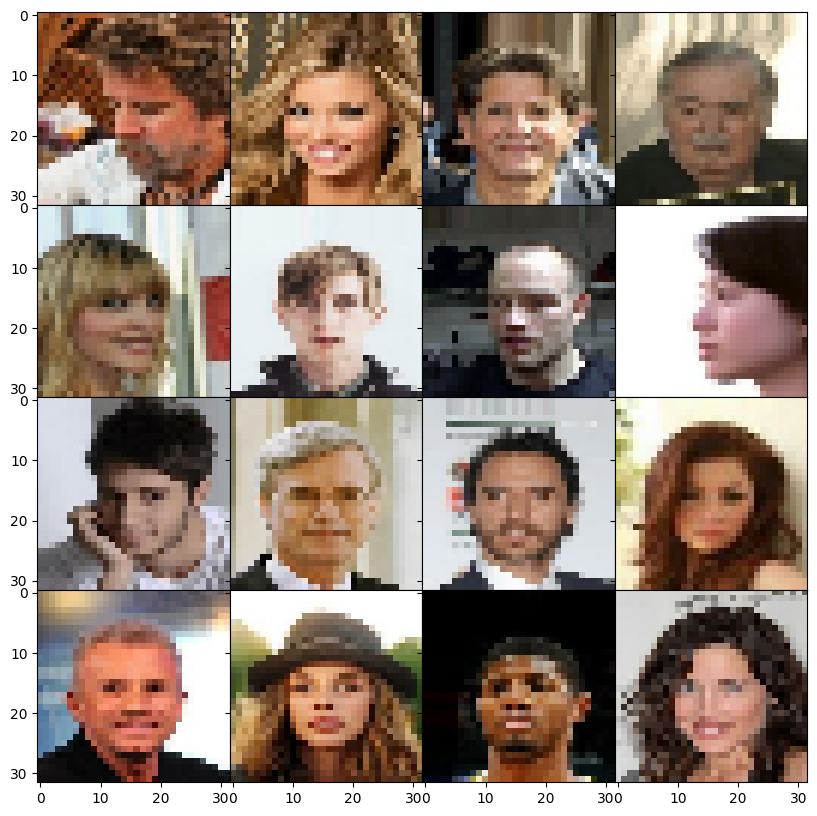

In [23]:
it = iter(dataset)
one_batch = next(it).numpy()
images = one_batch[:16,:,:,:]

#show the image
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig,111,nrows_ncols=(4,4),
          axes_pad=0)
for ax,im in zip(grid,images):
  ax.imshow(im)
plt.show()


GANs->Generative Adverserial Networks

Generator,Descriminator
Generator->Latent Noice
Descriminator->Real or Fake
Data Augmentation

In [29]:
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,LeakyReLU,Dropout,Flatten,Dense,Reshape,BatchNormalization
from tensorflow.keras import Model,Input

def discriminator_model():
  disc_input=Input(shape=(32,32,3))
  x= Conv2D(filters=64,kernel_size=(3,3),strides=(2,2),padding='same')(disc_input)
  x=LeakyReLU(alpha=0.2)(x)
  x=Dropout(0.25)(x)

  x= Conv2D(filters=128,kernel_size=(3,3),strides=(2,2),padding='same')(x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Dropout(0.25)(x)

  x= Conv2D(filters=128,kernel_size=(3,3),strides=(2,2),padding='same')(x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Dropout(0.25)(x)

  x= Conv2D(filters=64,kernel_size=(3,3),strides=(2,2),padding='same')(x)
  x=LeakyReLU(alpha=0.2)(x)
  x=Dropout(0.25)(x)

  x=Flatten()(x)
  output=Dense(1,activation='sigmoid')(x)

  discriminator=Model(disc_input,output,name='discriminator')
  return discriminator


discriminator=discriminator_model()
discriminator.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 2, 2, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,281 (1.13 MB)

 Trainable params: 297,281 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
def generator_model(z_dim=100):
  gen_input=Input(shape=(z_dim,),name='generator_network')
  x=Dense(units=8*8*3)(gen_input)
  x=Reshape(target_shape=(8,8,3))(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2DTranspose(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2DTranspose(filters=256,kernel_size=(3,3),strides=(2,2),padding='same')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2DTranspose(filters=128,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2DTranspose(filters=128,kernel_size=(3,3),strides=(2,2),padding='same')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2DTranspose(filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=LeakyReLU(alpha=0.2)(x)

  x=Conv2DTranspose(filters=3,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  fake_images_gen=LeakyReLU(alpha=0.2)(x)
  model=Model(inputs=gen_input,outputs=fake_images_gen)
  return model


generator=generator_model()
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ generator_network (InputLayer)       │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 192)                 │          19,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 3)             │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 8, 8, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 512)           │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 64)          │             2

 Total params: 1,736,143 (6.62 MB)

 Trainable params: 1,733,961 (6.61 MB)

 Non-trainable params: 2,182 (8.52 KB)

In [31]:
# Compile the model that trains discriminator
discriminator.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.0002,0.5),metrics=['accuracy'])

In [32]:
# Compile the model that trains generator
z_dim=100
generator.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.0002,0.5))
discriminator.trainable=False
model_input=Input(shape=(z_dim,),name='model_input')
model_output=discriminator(generator(model_input))
model=Model(model_input,model_output)
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.0002,0.5),metrics=['accuracy'])

In [33]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ model_input (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 32, 32, 3)           │       1,736,143 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ discriminator (Functional)           │ (None, 1)                   │         297,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,033,424 (7.76 MB)

 Trainable params: 1,733,961 (6.61 MB)

 Non-trainable params: 299,463 (1.14 MB)

In [43]:
def train_discriminator(batch,batch_size):
  valid=np.ones((batch_size,1))
  fake=np.zeros((batch_size,1))

  discriminator.train_on_batch(batch,valid)
  # Generate images and check if None
  gen_images_pred = generator.predict(np.random.normal(0,1,size=(batch_size,z_dim)))
  if gen_images_pred is None:
    print("Error: generator.predict returned None")
    return  # Exit the function to prevent further errors
  # Train on predicted images (remove the assignment to gen_images)
  discriminator.train_on_batch(gen_images_pred, fake)

def train_generator(batch_size):
  valid=np.ones((batch_size,1))
  noise=np.random.normal(0,1,size=(batch_size,z_dim))
  model.train_on_batch(noise,valid)


def save_image(fake_image,path):
  image=tf.keras.preprocessing.image.array_to_img(fake_image.numpy())
  tf.keras.preprocessing.image.save_img(path,image)
  return image
def generate_and_save_images(path):
  noise=np.random.normal(0,1,size=(1,z_dim))
  fake_images=generator(noise)
  image=save_image(fake_images[0],path)
  plt.imshow(image)
  plt.show()

In [39]:
import os

# Specify the directory path
directory_path = '/content/generatedFaces'

# Create the directory
os.makedirs(directory_path, exist_ok=True)

print(f"Directory '{directory_path}' created successfully!")


Directory '/content/generatedFaces' created successfully!


Epoch 1 of 10


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step
Batch Images :0


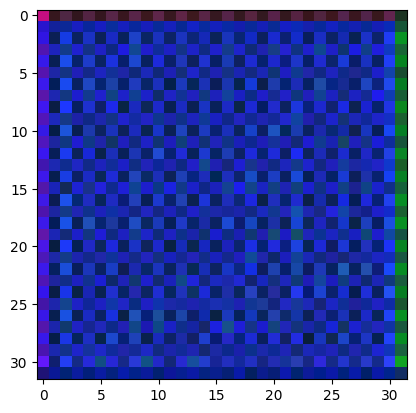

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 730ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 533ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 605ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 703ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
for epochs in range(10):
 print(f'Epoch {epochs+1} of 10')
 for i,batch in enumerate(dataset):
  train_discriminator(batch,batch_size=batch.shape[0])
  train_generator(batch_size=batch.shape[0])
  if i%100==0:
    print(f'Batch Images :{i}')
    generate_and_save_images(path=f'{directory_path}/epochs{epochs}batch_{i}.jpg')